# Basic ELM stock forecasting

## Implementing a simple ELM to forecast stock market prices. Computationally quick with fairly decent RMSE (play around with number of hidden neurons and the generation of the weights and biases to optimise RMSE though).

In [1]:
# importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error


In [2]:
#pick stock and read data, datasets downloaded from yahoo finance
stock = 'AAPL' # E.g. TSLA, MSFT, AAPL...
df = pd.read_csv(stock +'.csv', index_col = 'Date',
                       parse_dates=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1998-02-23,0.179688,0.193080,0.178571,0.189732,0.160627,477489600
1998-02-24,0.190290,0.190848,0.185268,0.190290,0.161099,456590400
1998-02-25,0.190290,0.203125,0.186942,0.199219,0.168659,712667200
1998-02-26,0.199219,0.210379,0.195313,0.209821,0.177634,595134400
1998-02-27,0.208147,0.213170,0.201451,0.210938,0.178580,519601600


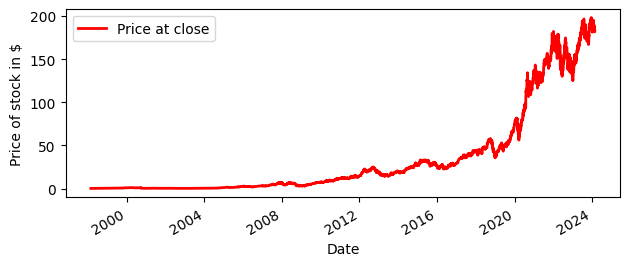

In [3]:
#Visualising data
fig = plt.figure()

#Plot price at close
ax1 = fig.add_subplot(211, xlabel ='Number of days', ylabel='Price of stock in $')
df['Close'].plot(ax=ax1, color='r', lw=2, label = 'Price at close')
ax1.legend()

plt.tight_layout()
plt.show()

In [4]:
#create 'sliding window' of data. Lag = how far in the future we want to predict


lag = 7

def sliding_window(time_series, lag):
    L = len(time_series)
    X = np.zeros((L-lag, lag))
    Y = np.zeros((L-lag,1))

    i = 0
    while lag + i < L:
        X[i,:] = time_series[i:lag+i]
        Y[i] = time_series[lag+i]
        i+=1
        
    return X, Y



    

In [5]:
#Splitting data

train_size = int(len(df) * 0.8)

time_series_train = df.Close[:train_size].values
time_train = df.Close[:train_size].index

time_series_test = df.Close[train_size:].values
time_test = df.Close[train_size:].index



# Normalising data
mean_train = np.mean(time_series_train)
sd_train = np.std(time_series_train)
time_series_train = (time_series_train-mean_train)/sd_train
time_series_test = (time_series_test-mean_train)/sd_train


x_train, y_train = sliding_window(time_series_train,lag)
x_test, y_test = sliding_window(time_series_test,lag)

In [6]:
# Generating weights and biases (normally distributed)
number_hidden_neurons = 50

input_weights = np.random.normal(0, 1, size=(lag, number_hidden_neurons))
print(np.shape(input_weights))

biases = np.random.normal(0, 1, size=(number_hidden_neurons))
print(np.shape(biases))

# Activation function (RELU function here)
def activation(x):     
    return np.maximum(x, 0, x)

(7, 50)
(50,)


In [7]:
# fitting
def fit(x):
    G = np.dot(x, input_weights) + biases
    H = activation(G)
    return H

# ELM formula tells us that y = B H implies B = H^-1 y
output_weights = np.dot(pinv(fit(x_train)), y_train)

# Prediction
def predict(x):
    out = np.dot(fit(x), output_weights)
    return out

prediction = predict(x_test)

#renormalise outputs
prediction = (prediction*sd_train) + mean_train

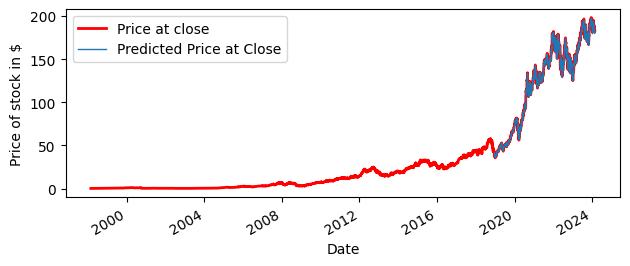

In [8]:
fig = plt.figure()


#Plot price at close
ax1 = fig.add_subplot(211, xlabel ='Number of days', ylabel='Price of stock in $')
df['Close'].plot(ax=ax1, color='r', lw=2, label = 'Price at close')

# Plot predictions
ax1.plot(time_test[lag:], prediction, lw=1.0, label = 'Predicted Price at Close')
ax1.legend()

plt.tight_layout()
plt.show()

In [9]:

y_test = (y_test*sd_train) + mean_train

# RMSE
rmse = math.sqrt(mean_squared_error(y_test, prediction))
print('Test RMSE: %.2f' % rmse)

Test RMSE: 2.50


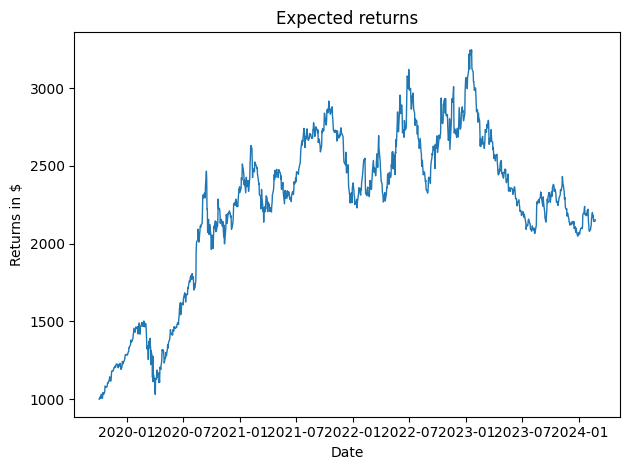

In [10]:
# Using model to buy/sell.

#initialise
capital= 1000
start_date = (df.index)[0]
end_date = (df.index)[-1]


#extracting data
prices = df.loc[start_date:end_date,'Close'].to_numpy()
logdat = df.loc[start_date:end_date,'Close'].apply(np.log).diff()

#extracting predicted data
logdat_pred = np.diff(np.log(prediction),axis=0)


#short and long windows
short = 50
long = 200

#generate the rolling short/long term average
running_short = prices[train_size +long-short:train_size +long].mean()
running_long = prices[train_size:train_size +long].mean()


#If the short term average exceeds the long signal will tell us to buy, vice-versa for selling
def event(running_short, running_long):
    return np.sign(running_short - running_long)

rets = [0]
for i in range(train_size+long, len(df)-lag-1):
    running_short+=(logdat_pred[i-train_size][0] - prices[i-train_size-short])/short
    running_long+=(logdat_pred[i-train_size][0] - prices[i-train_size-long])/long
    rets.append(rets[-1] + (event(running_short, running_long) * (logdat.iloc[i])))

out = np.exp(rets)*capital

#Plot Returns
plt.plot(time_test[lag+long:], out, lw=1.0)
plt.xlabel('Date')
plt.ylabel('Returns in $')
plt.title('Expected returns')
plt.tight_layout()
plt.show()






